# Pytorch

In [1]:
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np
from utils.utils import driving_area_mask,lane_line_mask

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
path_model = "data/weights/model.pt"
model = torch.jit.load(path_model, map_location=device)
print("Device:", device)
model = model.to(device)

Device: cuda


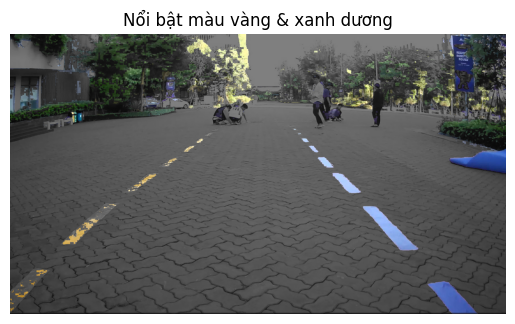

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Đọc ảnh
image = cv2.imread("2.jpg")
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Mask màu vàng (yellow)
lower_yellow = np.array([20, 50, 50])
upper_yellow = np.array([35, 255, 255])
mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

# Mask màu xanh dương (blue)
lower_blue = np.array([50, 50, 50])
upper_blue = np.array([130, 255, 255])
mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

# Gộp mask
mask = cv2.bitwise_or(mask_yellow, mask_blue)

# Tạo bản sao tối hơn/xám của ảnh gốc
gray_background = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_background = cv2.cvtColor(gray_background, cv2.COLOR_GRAY2BGR)
gray_background = cv2.convertScaleAbs(gray_background, alpha=0.5, beta=0)  # tối hơn nữa

# Chỉ giữ lại phần màu vàng & xanh dương
highlighted = np.where(mask[:, :, None] > 0, image, gray_background)

# Hiển thị ảnh kết quả
plt.imshow(cv2.cvtColor(highlighted, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Nổi bật màu vàng & xanh dương")
plt.show()


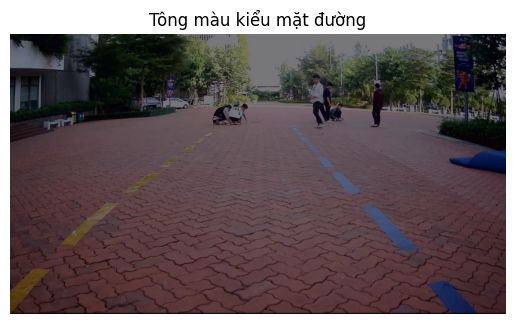

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Đọc ảnh
path_image = "2.jpg"
img0 = image = cv2.imread(path_image)

# Giảm độ sáng
darker = cv2.convertScaleAbs(image, alpha=0.6, beta=-20)  # alpha < 1: giảm tương phản, beta < 0: tối đi

# Thêm tông màu lạnh (hơi xanh-xám)
blue_tint = np.full_like(darker, (30, 0, 0))  # Thêm một chút xanh dương vào
dark_road_style = cv2.addWeighted(darker, 0.9, blue_tint, 0.1, 0)

# Chuyển sang RGB để hiển thị với matplotlib
image_BGR = cv2.cvtColor(dark_road_style, cv2.COLOR_BGR2RGB)

# Hiển thị
plt.imshow(image_BGR)
plt.axis('off')
plt.title("Tông màu kiểu mặt đường")
plt.show()


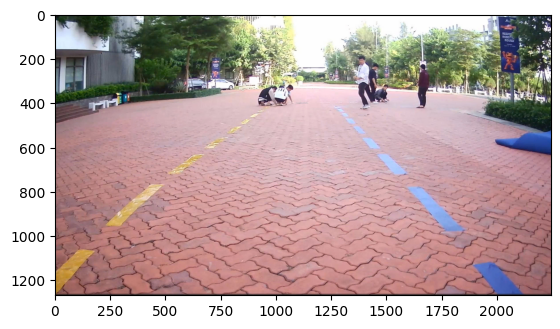

In [3]:
path_image = "2.jpg"
img0 = image = cv2.imread(path_image)

image_BRG = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_BRG)

In [4]:
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)
    #print(sem_img.shape)
    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])

    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
     
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))

    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    
    return img, ratio, (dw, dh)

In [21]:

img0 = cv2.resize(highlighted, (1280,720), interpolation=cv2.INTER_LINEAR)
img = letterbox(img0, 640, stride=32)[0]

img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
img = np.ascontiguousarray(img)

img = torch.from_numpy(img).to(device)
img = img.float()
img /= 255.0 

if img.ndimension() == 3:
    img = img.unsqueeze(0)
[pred,anchor_grid],seg,ll= model(img)

da_seg_mask = driving_area_mask(seg)
ll_seg_mask = lane_line_mask(ll)

In [22]:
da_seg_mask = driving_area_mask(seg)
ll_seg_mask = lane_line_mask(ll)

In [7]:
np.unique(da_seg_mask)

array([0, 1])

In [23]:
# Mask overlay
img0[da_seg_mask > 0] = (0, 255, 0)
img0[ll_seg_mask > 0] = (0, 0, 255)

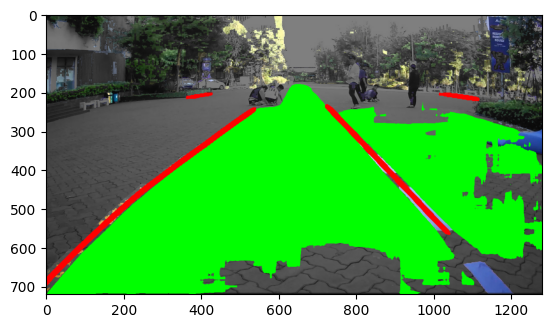

In [24]:
plt.imshow(cv2.cvtColor(img0,cv2.COLOR_BGR2RGB))

# ONNX

In [21]:
import onnxruntime

# Khởi tạo session
onnx_session = onnxruntime.InferenceSession(
    'data\\weights\\model_384x640.onnx',
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider'],
)

# Hiển thị thông tin các output
print("Outputs của mô hình:")
for output in onnx_session.get_outputs():
    print(f"- Tên: {output.name}")
    print(f"  Kiểu dữ liệu: {output.type}")
    print(f"  Shape: {output.shape}")


Outputs của mô hình:
- Tên: seg
  Kiểu dữ liệu: tensor(float)
  Shape: [1, 2, 384, 640]
- Tên: ll
  Kiểu dữ liệu: tensor(float)
  Shape: [1, 1, 384, 640]
- Tên: pred0
  Kiểu dữ liệu: tensor(float)
  Shape: [1, 255, 48, 80]
- Tên: pred1
  Kiểu dữ liệu: tensor(float)
  Shape: [1, 255, 24, 40]
- Tên: pred2
  Kiểu dữ liệu: tensor(float)
  Shape: [1, 255, 12, 20]


In [18]:
import cv2

image = cv2.imread('data/example.jpg')

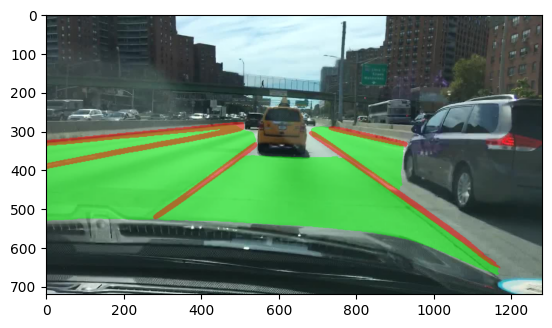

In [23]:
from utils import utils_onnx
import copy
import numpy as np

# Tiền xử lý
# Thực hiện padding cho ảnh đầu vào
input_image = copy.deepcopy(image)
input_image, _, (pad_w, pad_h) = utils_onnx.letterbox(input_image)

# Chuyển đổi từ BGR sang RGB và thay đổi thứ tự trục (CHW)
input_image = input_image[:, :, ::-1].transpose(2, 0, 1)
input_image = np.ascontiguousarray(input_image)

# Chuẩn hóa giá trị pixel
input_image = input_image.astype('float32')
input_image /= 255.0

# Thêm chiều batch (NCHW)
input_image = np.expand_dims(input_image, axis=0)

# Thực hiện suy luận (inference)
input_name = onnx_session.get_inputs()[0].name
results = onnx_session.run(None, {input_name: input_image})

# Phân đoạn khu vực có thể lái xe (đường đi)
result_road_seg = utils_onnx.driving_area_mask(
    results[0],
    (pad_w, pad_h),
)

# Phân đoạn làn đường
result_lane_seg = utils_onnx.lane_line_mask(
    results[1],
    (pad_w, pad_h),
)

debug_image = copy.deepcopy(image)

# Phân đoạn mặt đường
image_width, image_height = debug_image.shape[1], debug_image.shape[0]

# Tạo ảnh mask từ kết quả phân đoạn đường đi
road_mask = np.stack((result_road_seg, ) * 3, axis=-1).astype('float32')
road_mask = cv2.resize(
    road_mask,
    dsize=(image_width, image_height),
    interpolation=cv2.INTER_LINEAR,
)
road_mask = np.where(road_mask > 0.5, 0, 1)

# Trộn mask với ảnh gốc để tô màu vùng mặt đường
bg_image = np.zeros(debug_image.shape, dtype=np.uint8)
bg_image[:] = [0, 255, 0]  # tô màu xanh lá cây cho mặt đường
road_mask_image = np.where(road_mask, debug_image, bg_image)

# Trộn ảnh gốc và ảnh tô màu với độ trong suốt
debug_image = cv2.addWeighted(debug_image, 0.5, road_mask_image, 0.5, 1.0)

# Phân đoạn làn đường
# Tạo ảnh mask từ kết quả phân đoạn làn đường
road_mask = np.stack((result_lane_seg, ) * 3, axis=-1).astype('float32')
road_mask = cv2.resize(
    road_mask,
    dsize=(image_width, image_height),
    interpolation=cv2.INTER_LINEAR,
)
road_mask = np.where(road_mask > 0.5, 0, 1)

# Trộn mask với ảnh gốc để tô màu vùng làn đường
bg_image = np.zeros(debug_image.shape, dtype=np.uint8)
bg_image[:] = [0, 0, 255]  # tô màu đỏ cho làn đường
road_mask_image = np.where(road_mask, debug_image, bg_image)

# Trộn ảnh gốc và ảnh tô màu với độ trong suốt
debug_image = cv2.addWeighted(debug_image, 0.5, road_mask_image, 0.5, 1.0)

import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(debug_image,cv2.COLOR_BGR2RGB))